1. Генерация настоящих данных
Для начала создадим реальные точки на графике функции:

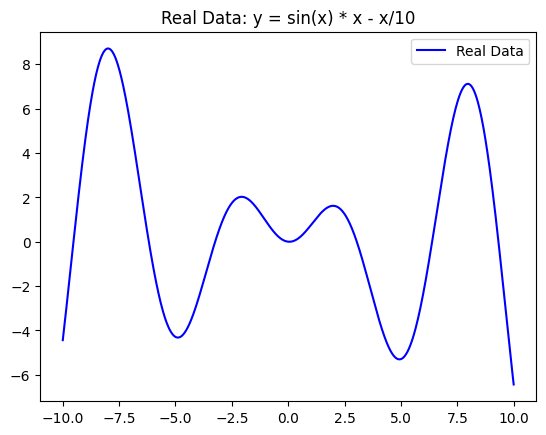

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Функция
def real_function(x):
    return np.sin(x) * x - x / 10

# Генерация настоящих данных
x_real = np.linspace(-10, 10, 1000)
y_real = real_function(x_real)

# Визуализация реальных данных
plt.plot(x_real, y_real, label="Real Data", color="blue")
plt.title("Real Data: y = sin(x) * x - x/10")
plt.legend()
plt.show()


2. Архитектура GAN
Генератор будет получать случайный вектор и генерировать значения
x и соответствующие
y, которые должны соответствовать функции.

Дискриминатор будет отличать реальные точки от сгенерированных.

In [2]:
import torch
import torch.nn as nn

# Генератор
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, z):
        return self.fc(z)

# Дискриминатор
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Параметры модели
input_size = 1  # Входной шум для генератора
hidden_size = 64  # Размер скрытого слоя
output_size = 2  # Генерируем 2 выхода: x и y

# Инициализация моделей
generator = Generator(input_size, hidden_size, output_size)
discriminator = Discriminator(output_size, hidden_size)

# Оптимизаторы
lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

# Функция потерь
loss_function = nn.BCELoss()


3. Обучение GAN
Теперь нужно реализовать процесс обучения. На каждом шаге будем обучать дискриминатор и генератор, а также генерировать данные и сравнивать их с реальными.

Epoch [0/10000] | Loss D: 0.5833, Loss G: 0.6045
Epoch [1000/10000] | Loss D: 0.5548, Loss G: 1.1534
Epoch [2000/10000] | Loss D: 0.3716, Loss G: 1.6559
Epoch [3000/10000] | Loss D: 0.4058, Loss G: 1.2158
Epoch [4000/10000] | Loss D: 0.4988, Loss G: 1.3558
Epoch [5000/10000] | Loss D: 0.4012, Loss G: 1.3498
Epoch [6000/10000] | Loss D: 0.5037, Loss G: 1.5607
Epoch [7000/10000] | Loss D: 0.5442, Loss G: 1.1668
Epoch [8000/10000] | Loss D: 0.4721, Loss G: 1.0271
Epoch [9000/10000] | Loss D: 0.4936, Loss G: 1.0079


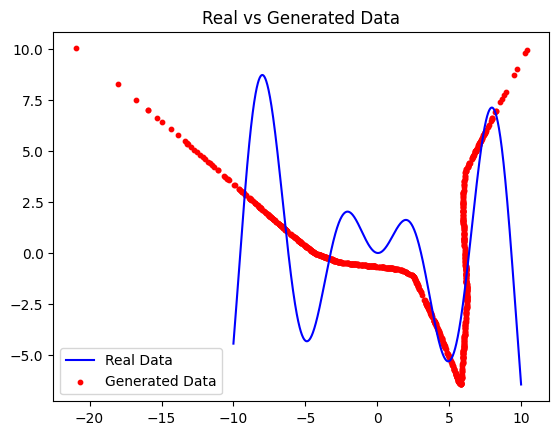

In [3]:
# Параметры обучения
num_epochs = 10000
batch_size = 64
z_dim = 1  # Размер случайного вектора

# Реальные данные в PyTorch
real_data = torch.tensor(np.column_stack((x_real, y_real)), dtype=torch.float32)

for epoch in range(num_epochs):
    # --- Тренировка дискриминатора ---
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # 1. Выбор случайных реальных данных
    idx = np.random.randint(0, real_data.shape[0], batch_size)
    real_batch = real_data[idx]

    # 2. Генерация фейковых данных
    z = torch.randn(batch_size, z_dim)
    fake_batch = generator(z)

    # 3. Обучение дискриминатора
    d_real = discriminator(real_batch)
    d_fake = discriminator(fake_batch)

    loss_real = loss_function(d_real, real_labels)
    loss_fake = loss_function(d_fake, fake_labels)
    loss_D = (loss_real + loss_fake) / 2

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # --- Тренировка генератора ---
    z = torch.randn(batch_size, z_dim)
    fake_batch = generator(z)

    # Дискриминатор должен считать фейковые данные реальными
    d_fake = discriminator(fake_batch)
    loss_G = loss_function(d_fake, real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    # Печать прогресса
    if epoch % 1000 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

# Генерация новых данных после обучения
z = torch.randn(1000, z_dim)
generated_data = generator(z).detach().numpy()

# Визуализация реальных и сгенерированных данных
plt.plot(x_real, y_real, label="Real Data", color="blue")
plt.scatter(generated_data[:, 0], generated_data[:, 1], label="Generated Data", color="red", s=10)
plt.legend()
plt.title("Real vs Generated Data")
plt.show()
